# Imports

In [770]:
import zipfile
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import calinski_harabasz_score

# Connect to drive

In [771]:
# # Mount to Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# # change directory to the folder where the data is stored
# %cd /content/drive/My Drive/SAT/project

# Helpers

In [772]:
def show_img(img,title=""):
   plt.imshow(img)
   plt.title(title)
   plt.show()

In [773]:
def extract_file(zip_path,specified_directory):
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(specified_directory)

In [774]:
def read_images(flooded_path,non_flooded_path,width,height):
    flooded = np.empty((0, width, height, 3))
    non_flooded = np.empty((0, width, height, 3))

    for filename in os.listdir(flooded_path):
        img = cv2.imread(os.path.join(flooded_path, filename), cv2.IMREAD_COLOR)
        img = cv2.resize(img, (width, height)) 
        img = img.astype('float32') / 255.0 
        img = np.expand_dims(img, axis=0)
        flooded = np.concatenate((flooded, img), axis=0)

    for filename in os.listdir(non_flooded_path):
        img = cv2.imread(os.path.join(non_flooded_path, filename), cv2.IMREAD_COLOR)
        img = cv2.resize(img, (width, height)) 
        img = img.astype('float32') / 255.0  
        img = np.expand_dims(img, axis=0) 
        non_flooded = np.concatenate((non_flooded, img), axis=0)
    return flooded,non_flooded

In [775]:
def show_images(images,images_labels):
  nrows = 4
  ncols = 4
  fig, ax = plt.subplots(nrows,ncols,figsize = (10,10))
  ax = ax.flatten()
  for i in range(nrows*ncols):
      pic = images[i%8]
      ax[i].imshow(pic)
      ax[i].set_title(images_labels[i%8])
      ax[i].set_axis_off()
  plt.show()

# Constants

In [776]:
CFG = {
    'img_size': 512, # width and height of the image
    'dataset_path': 'dataset', # path to the root dataset folder
    'flooded_path': 'dataset/flooded', # path to the flooded images
    'non_flooded_path': 'dataset/non-flooded', # path to the non flooded images
    }

# Images reading

In [777]:
# extract_file("./dataset.zip","./dataset")

In [778]:
flooded,non_flooded=read_images(CFG['flooded_path'], CFG['non_flooded_path'], CFG['img_size'], CFG['img_size'])
print("flooded images shapes",flooded.shape)
print("non_flooded images shapes",non_flooded.shape)

flooded images shapes (16, 512, 512, 3)
non_flooded images shapes (0, 512, 512, 3)


# Images preprocessing

In [779]:
from scipy import signal
def preprocess_img(img, t):

  # turn to 255
  img = img * 255
  img = img.astype(np.uint8)

  # # gaussian blur
  # img = cv2.GaussianBlur(img, (5, 5), 0)

  # # Convert the image to Lab color space
  # lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
  # # Split the Lab image into L and ab channels
  # l, a, b = cv2.split(lab)
  # # Apply CLAHE to the L channel
  # clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
  # l_equalized = clahe.apply(l)
  # # Merge the equalized L channel with the original ab channels
  # lab_equalized = cv2.merge((l_equalized, a, b))
  # # Convert the equalized Lab image back to RGB
  # img = cv2.cvtColor(lab_equalized, cv2.COLOR_LAB2BGR)

  # # dilation
  # img = cv2.dilate(img, np.ones((3,3), np.uint8), iterations=1)

  # # Histogram equalization
  # R, G, B = cv2.split(img)
  # output1_R = cv2.equalizeHist(R)
  # output1_G = cv2.equalizeHist(G)
  # output1_B = cv2.equalizeHist(B)
  # img = cv2.merge((output1_R, output1_G, output1_B))

  # # Gaussian blur
  # img = cv2.GaussianBlur(img, (5, 5), 0)

  # # median blur
  # img = cv2.medianBlur(img, 3)

  # # convert ot HSV
  # img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

  # # blur
  # img = cv2.GaussianBlur(img, (3, 3), 0)

  # # median blur
  # img = cv2.medianBlur(img, 3)

  # convert to LAB
  # img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

  # Combine HSV and LAB
  if t == 0:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  elif t == 1:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

  return img / 255

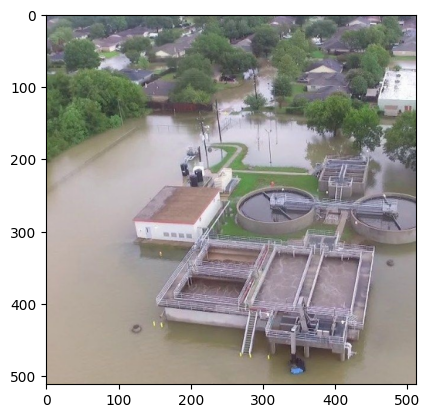

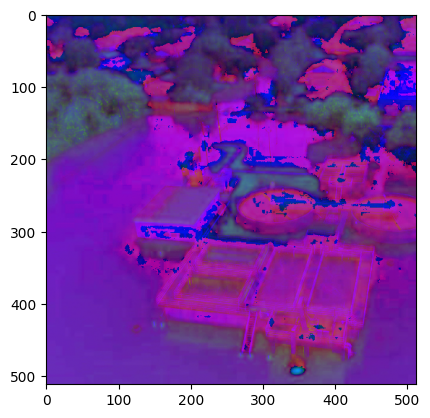

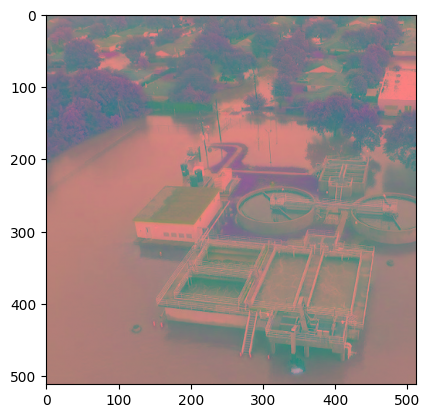

In [780]:
img = flooded[1].astype('float32')
show_img(img)
show_img(preprocess_img(img, 0))
show_img(preprocess_img(img, 1))

# K-means segmentation

In [781]:
def segment_kmeans(img, t, min_clusters=2, max_clusters=3):

  # preprocess the image
  img_arr = preprocess_img(img, t)

  # Reshape the image array to a 2D array of pixels
  img_pixels = img_arr.reshape(-1, img_arr.shape[-1])

  # Scale the pixel values to improve the clustering performance
  scaler = StandardScaler()
  img_pixels_scaled = scaler.fit_transform(img_pixels)

  best_ch_score = 0
  best_cluster_labels = None
  best_n_clusters = 0
  for k in range(min_clusters, max_clusters+1):

    # Initialize the k-means algorithm
    kmeans = KMeans(n_clusters=k, n_init='auto')

    # Fit the algorithm to the data
    kmeans.fit(img_pixels_scaled)

    # Get the cluster labels for each pixel
    cluster_labels = kmeans.labels_

    # Compute the Calinski-Harabasz index for the clustering solution
    ch_score = calinski_harabasz_score(img_pixels_scaled, cluster_labels)

    # save best result
    if (ch_score > best_ch_score and ch_score - best_ch_score > 30000) or (ch_score < best_ch_score and best_ch_score - ch_score < 30000):
      best_ch_score = ch_score
      best_cluster_labels = cluster_labels
      best_n_clusters = k
    
  # Print the best Calinski-Harabasz score
  print("The best Calinski-Harabasz score is:", best_ch_score)

  # Print the best n_clusters
  print("The best n_clusters is:", best_n_clusters)

  # Reshape the cluster labels to the original image shape
  clustered_img = best_cluster_labels.reshape(img_arr.shape[:2])

  # Visualize the original image and the clustered image
  fig, ax = plt.subplots(1, 3)
  ax[0].imshow(img)
  ax[0].set_title('Original Image')
  ax[1].imshow(img_arr)
  ax[1].set_title('Preprocessed Image')
  ax[2].imshow(clustered_img)
  ax[2].set_title('Clustered Image')
  plt.show()

  return clustered_img, best_ch_score

In [782]:
def segment_combinations(img, num_combinations=2):
    final_ch_score = 0
    finaal_clustered_img = None
    # Try different combinations of preprocessing steps
    for i in range(num_combinations):
        clustered_img, ch_score = segment_kmeans(img, i)
        if (ch_score > final_ch_score and ch_score - final_ch_score > 40000) or (ch_score < final_ch_score and final_ch_score - ch_score < 40000):
            final_ch_score = ch_score
            finaal_clustered_img = clustered_img
    # Visualize the original image and the clustered image
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img)
    ax[0].set_title('Original Image')
    ax[1].imshow(finaal_clustered_img)
    ax[1].set_title('Best Clustered Image')
    plt.show()

The best Calinski-Harabasz score is: 261252.38328750664
The best n_clusters is: 2


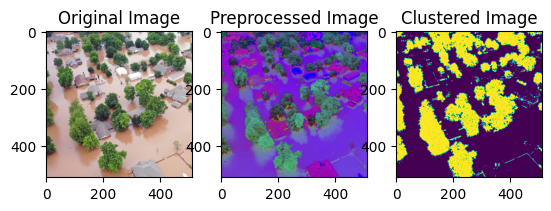

The best Calinski-Harabasz score is: 382737.7832470509
The best n_clusters is: 2


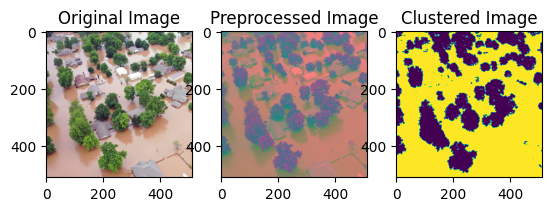

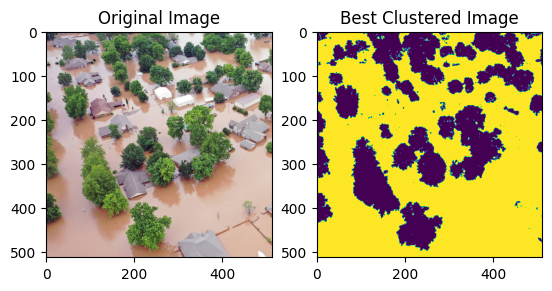

The best Calinski-Harabasz score is: 148444.6615132202
The best n_clusters is: 3


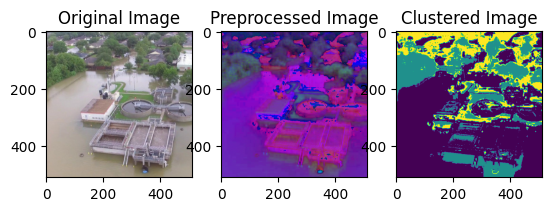

The best Calinski-Harabasz score is: 181744.15407209296
The best n_clusters is: 3


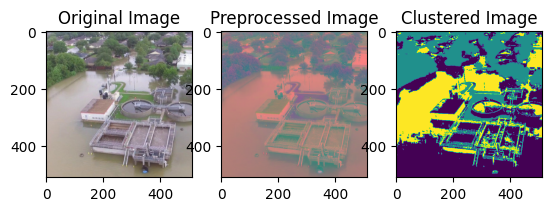

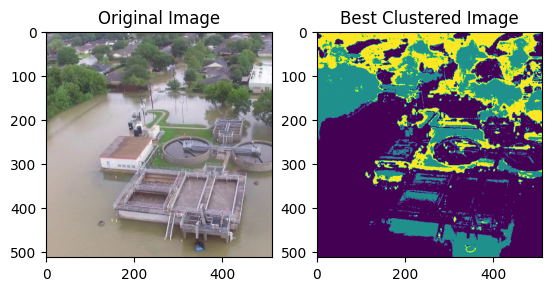

The best Calinski-Harabasz score is: 180685.5606973552
The best n_clusters is: 2


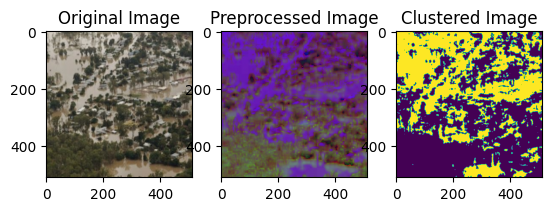

The best Calinski-Harabasz score is: 143833.67193084373
The best n_clusters is: 3


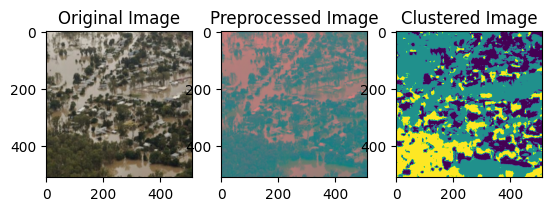

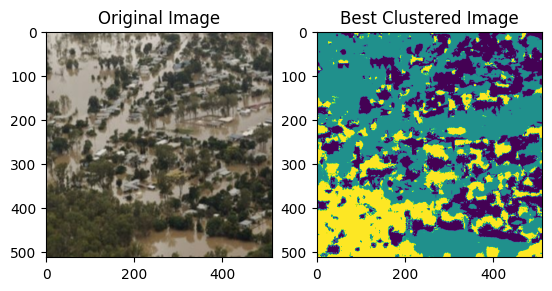

The best Calinski-Harabasz score is: 180659.4792002097
The best n_clusters is: 2


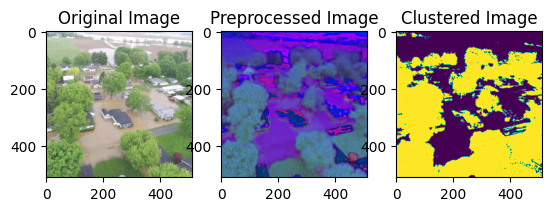

The best Calinski-Harabasz score is: 343364.49871964596
The best n_clusters is: 2


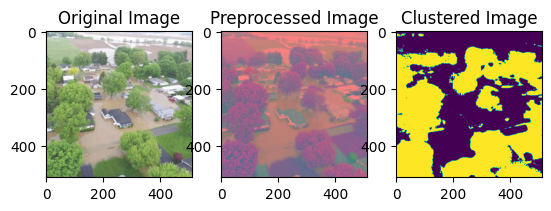

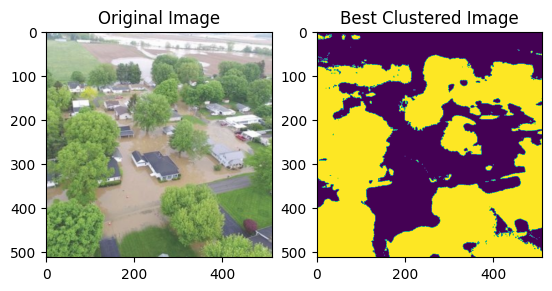

The best Calinski-Harabasz score is: 178768.3990150127
The best n_clusters is: 3


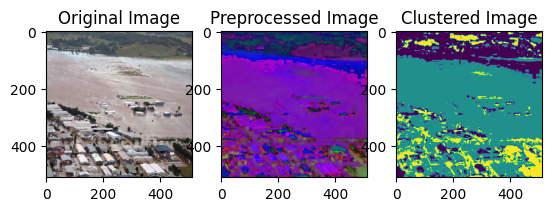

The best Calinski-Harabasz score is: 130479.11189283882
The best n_clusters is: 3


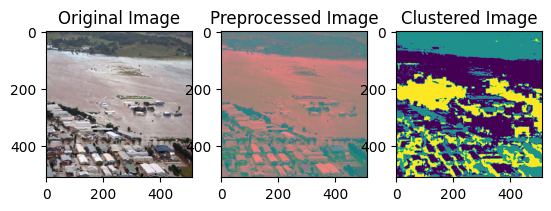

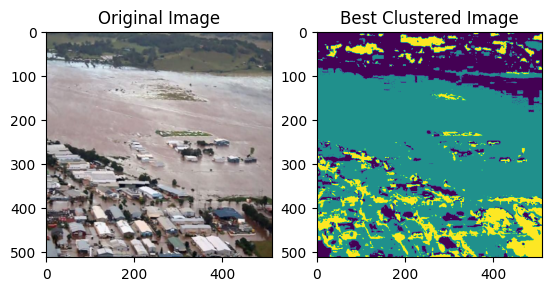

The best Calinski-Harabasz score is: 410432.225421371
The best n_clusters is: 3


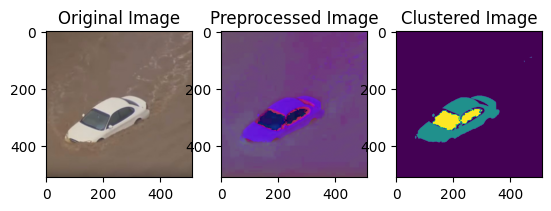

The best Calinski-Harabasz score is: 183889.6413966205
The best n_clusters is: 2


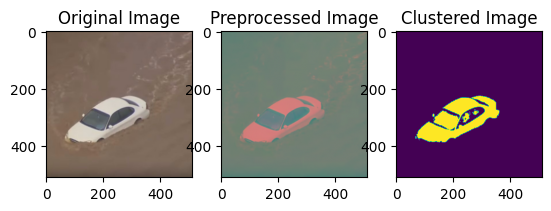

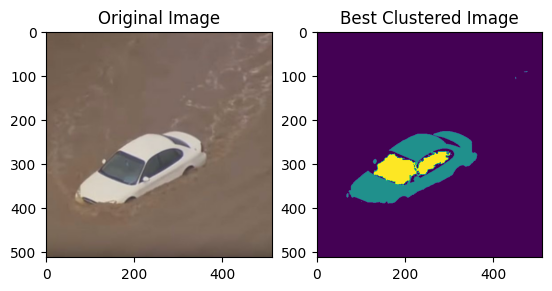

The best Calinski-Harabasz score is: 118586.93231817185
The best n_clusters is: 3


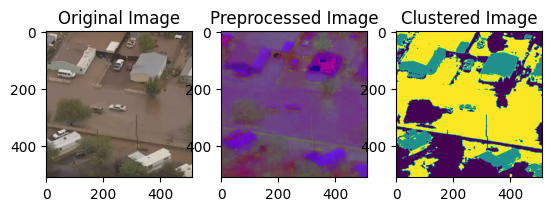

The best Calinski-Harabasz score is: 211968.2130181819
The best n_clusters is: 3


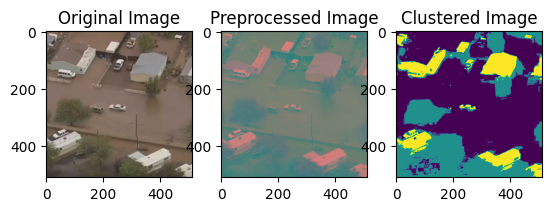

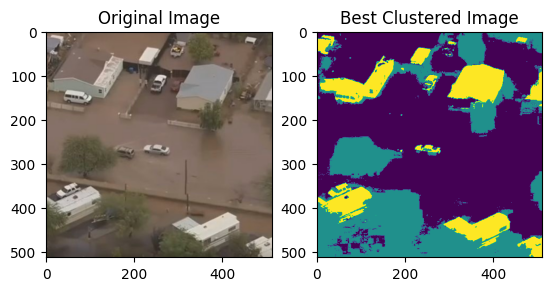

The best Calinski-Harabasz score is: 120957.79935500007
The best n_clusters is: 2


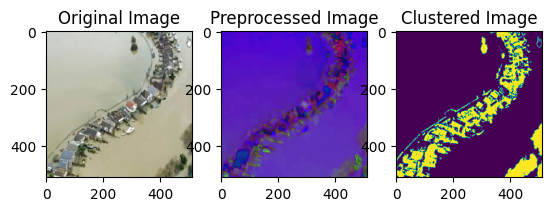

The best Calinski-Harabasz score is: 134256.0627407219
The best n_clusters is: 2


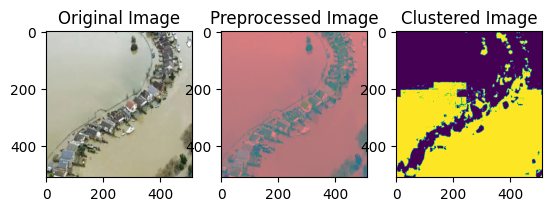

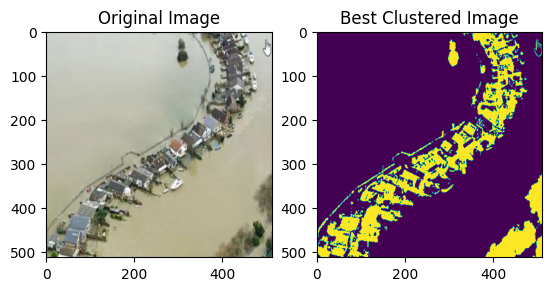

The best Calinski-Harabasz score is: 92634.06454402923
The best n_clusters is: 2


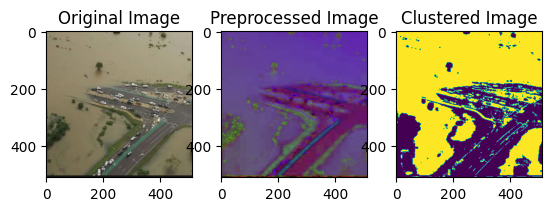

The best Calinski-Harabasz score is: 204082.0012460772
The best n_clusters is: 3


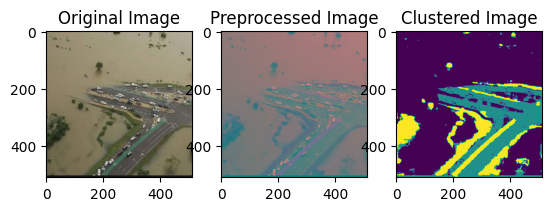

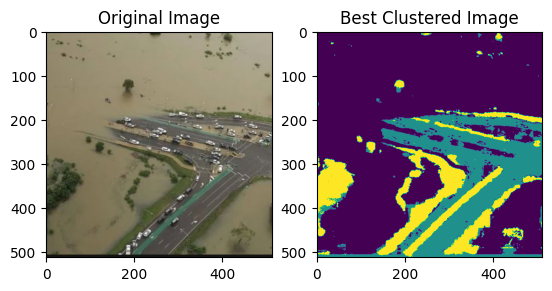

The best Calinski-Harabasz score is: 124355.73835216857
The best n_clusters is: 2


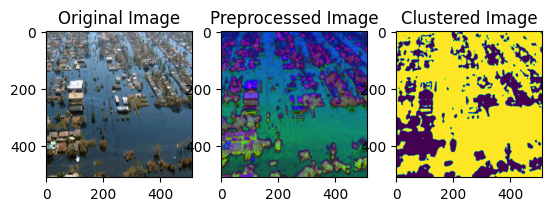

The best Calinski-Harabasz score is: 171828.3570817872
The best n_clusters is: 3


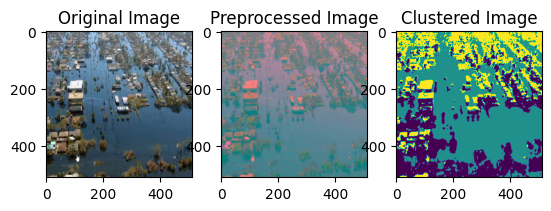

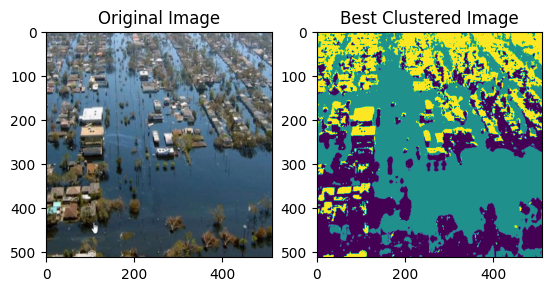

The best Calinski-Harabasz score is: 238434.62220207357
The best n_clusters is: 2


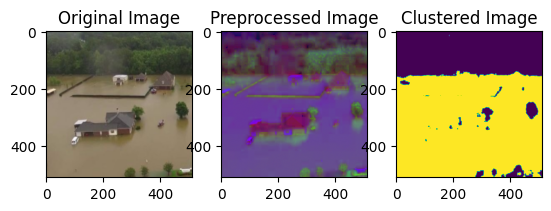

The best Calinski-Harabasz score is: 305959.16376227356
The best n_clusters is: 2


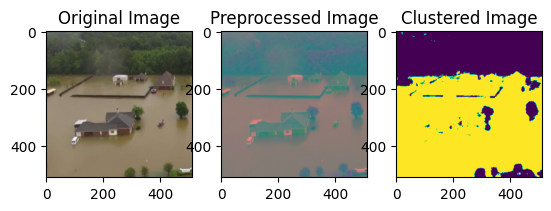

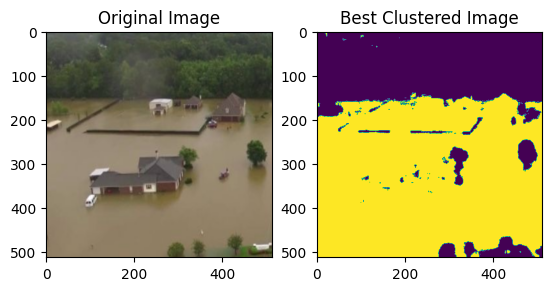

The best Calinski-Harabasz score is: 360059.1388680011
The best n_clusters is: 3


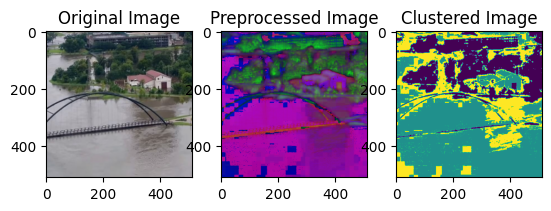

The best Calinski-Harabasz score is: 323900.72693447134
The best n_clusters is: 2


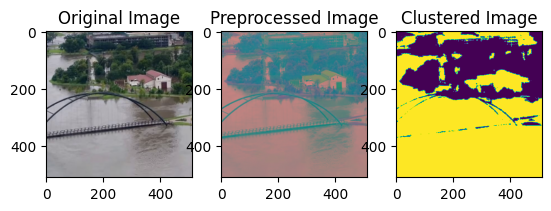

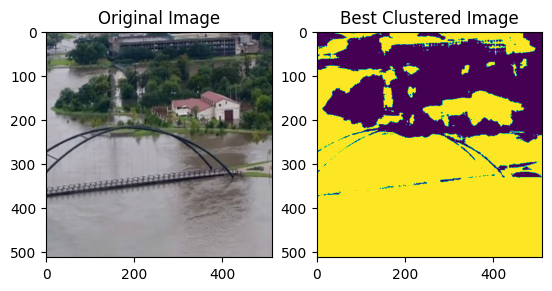

The best Calinski-Harabasz score is: 173270.28168147165
The best n_clusters is: 2


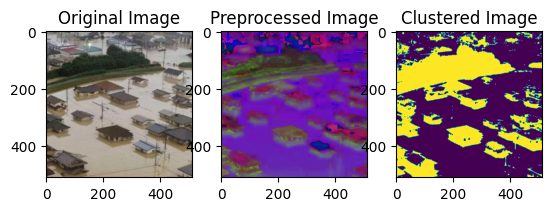

The best Calinski-Harabasz score is: 121104.34299968778
The best n_clusters is: 2


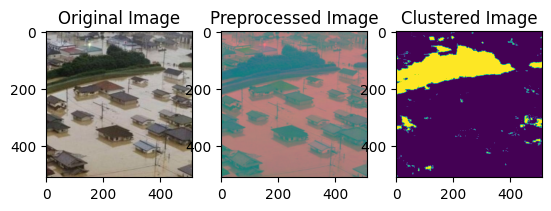

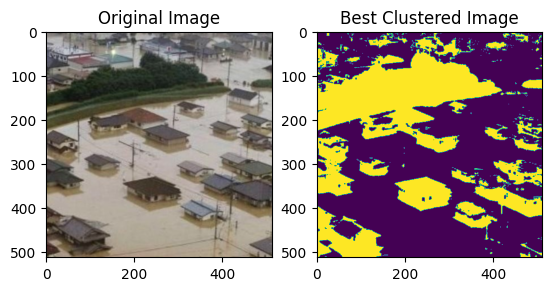

The best Calinski-Harabasz score is: 294925.753857833
The best n_clusters is: 3


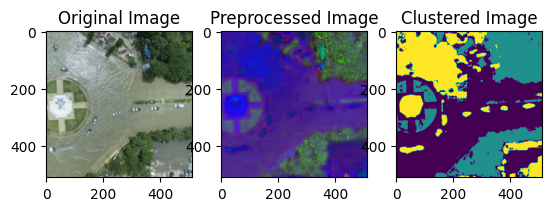

The best Calinski-Harabasz score is: 211987.84341464698
The best n_clusters is: 3


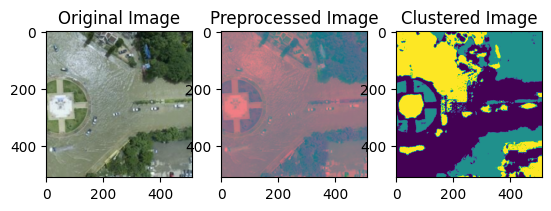

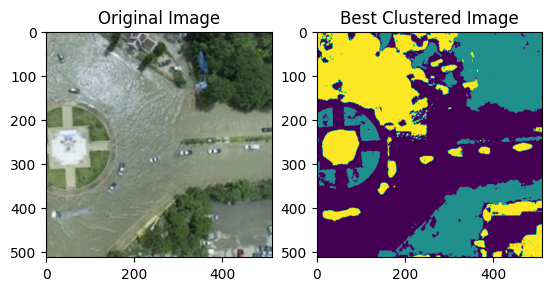

The best Calinski-Harabasz score is: 264260.6903410874
The best n_clusters is: 3


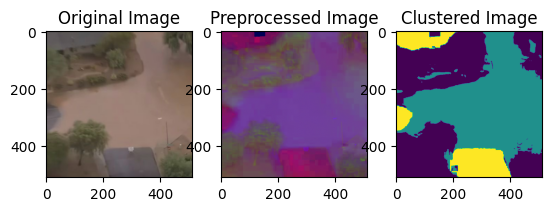

The best Calinski-Harabasz score is: 366270.7999039984
The best n_clusters is: 2


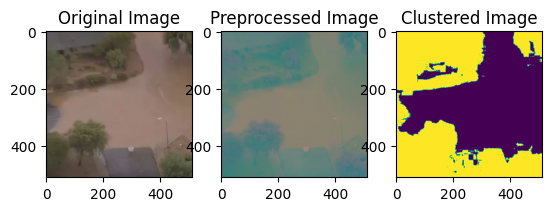

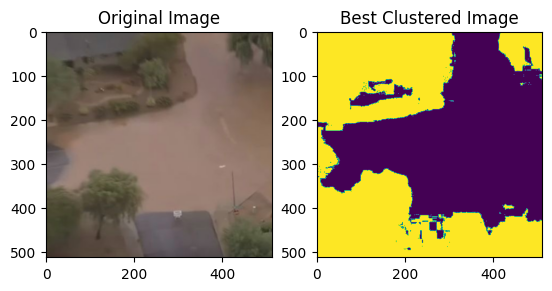

The best Calinski-Harabasz score is: 164730.05289648543
The best n_clusters is: 3


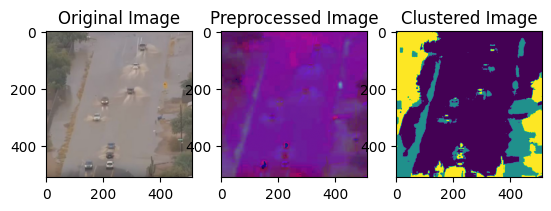

The best Calinski-Harabasz score is: 181572.49980999148
The best n_clusters is: 2


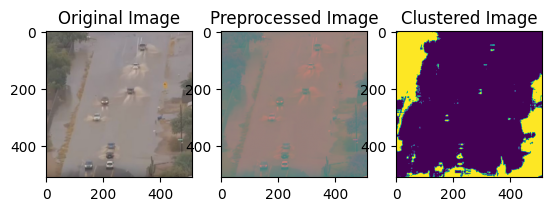

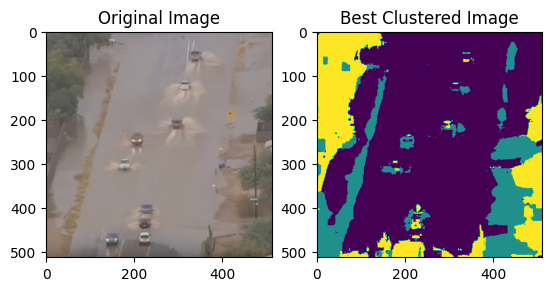

In [783]:
for i in range(len(flooded)):
    segment_combinations(flooded[i])